# Задача 2. Сравнение методов классификации

Паршин Максим Алексеевич, 22.М07-мм

+ Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
+ Взять данные для предсказания заболеваний сердца тут (целевой признак для предсказания --- target). Демо блокнот с анализом этих данных можно найти тут.
+ Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
+ Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
+ При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
+ Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
+ Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
+ Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
+ (+2 балла) Реализовать еще один из методов классификации и добавить его в сравнение.
+ (+2 балла) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

# 1. Анализ данных (heart)

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y


warnings.filterwarnings('ignore')

In [286]:
data = pd.read_csv('heart.csv')

In [287]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [288]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

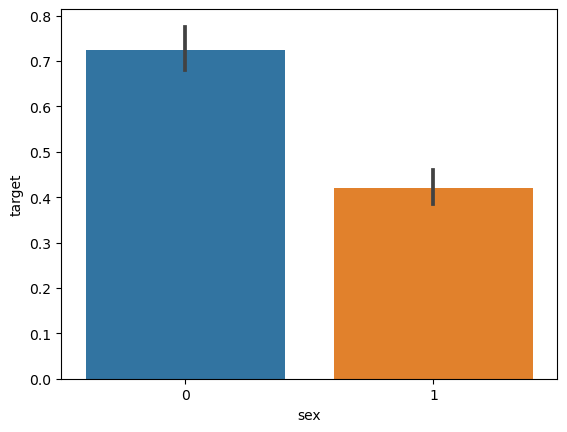

In [289]:
sns.barplot(x = "sex", y = "target", data = data);

Заболевание обнаружено у более чем 70% женщин, и только у 40% мужчин. Этот признак полезен, оставляем его как есть.

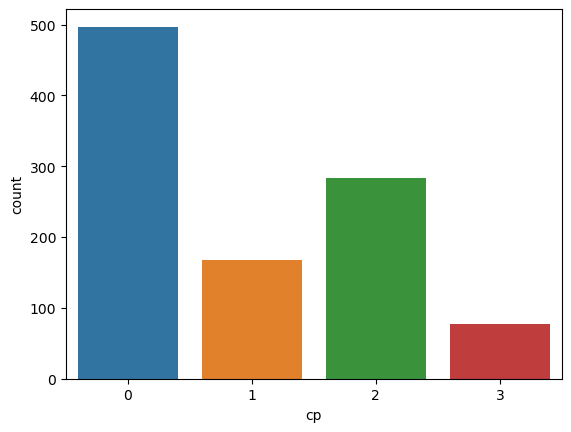

In [290]:
sns.countplot(x = "cp", data = data);

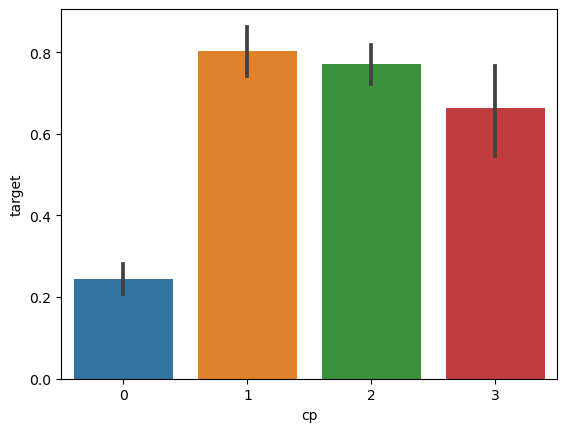

In [291]:
sns.barplot(x = "cp", y = "target", data = data);

Отсутствие боли в груди -- достаточно хороший признак того, что заболевание отсутствует. С другой стороны, люди, у которых ничего не болит с меньшей вероятностью обратятся к врачу. Что касается различных типов боли, при любом типе вероятность иметь заболевание достаточно высока. Преобразуем данный признак в бинарный.

In [292]:
data['cp'] = data['cp'].map(lambda cp: 1 if cp > 0 else 0)

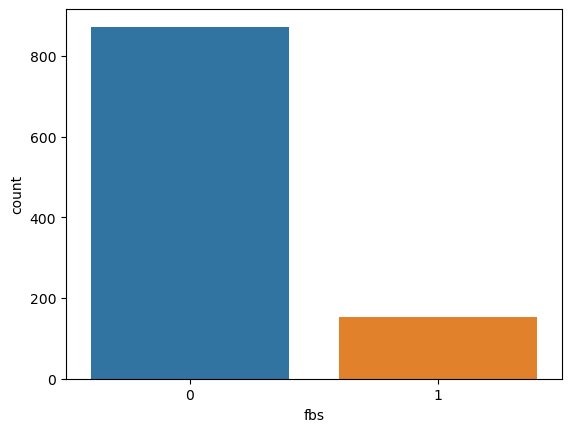

In [293]:
sns.countplot(x = "fbs", data = data);

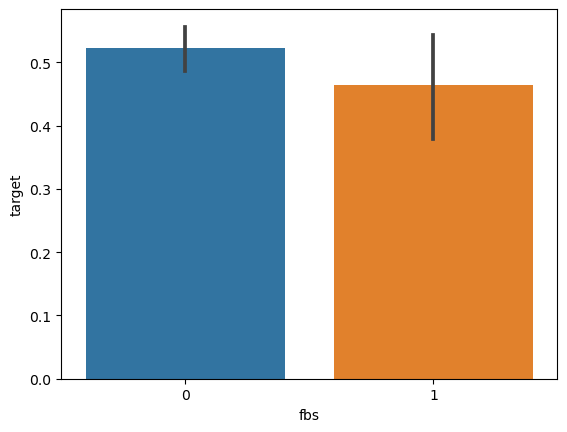

In [294]:
sns.barplot(x = "fbs", y = "target", data = data);

Повышенный уровень сахара в крови ничего не означает: и с ним, и без него, вероятность того, что пациент болен, около 50%. При этом выборка пациентов с повышенным сахаром в целом невелика. Исключим данный признак.

In [295]:
data.drop(['fbs'], axis=1, inplace = True);

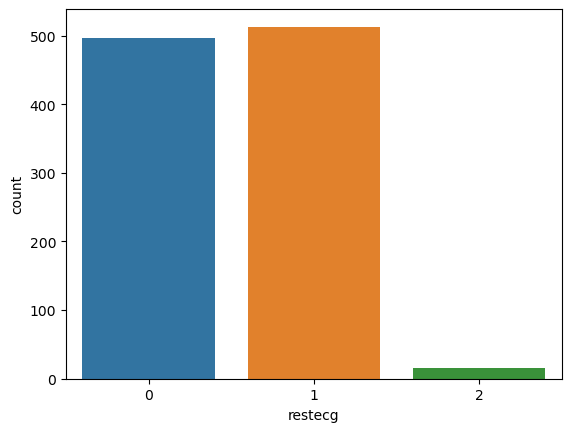

In [296]:
sns.countplot(x = "restecg", data = data);

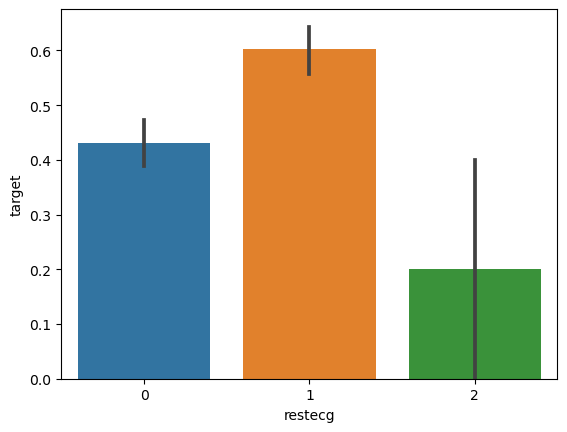

In [297]:
sns.barplot(x = "restecg", y = "target", data = data);

По результатам кардиограммы также сложно сделать предположения о том, имеется ли у пациента заболевание. Исключим данный признак. 

In [298]:
data.drop(['restecg'], axis=1, inplace = True);

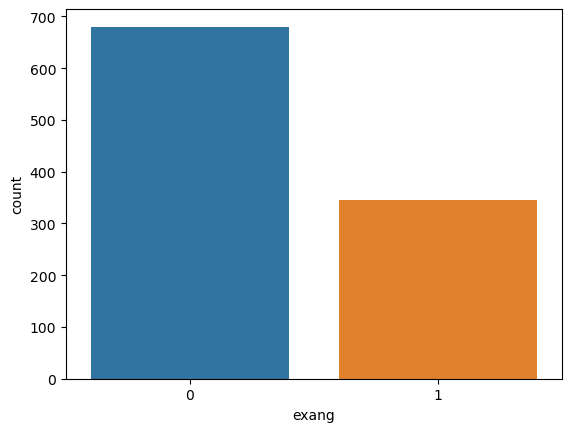

In [299]:
sns.countplot(x = "exang", data = data);

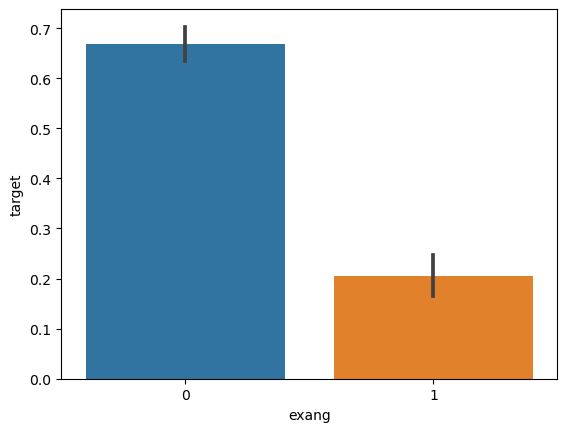

In [300]:
sns.barplot(x = "exang", y = "target", data = data);

Интересные показатели: среди пациентов, у которых физические упражнения вызывают ангину, почти 70% имели порок сердца. Оставим данный признак как есть.

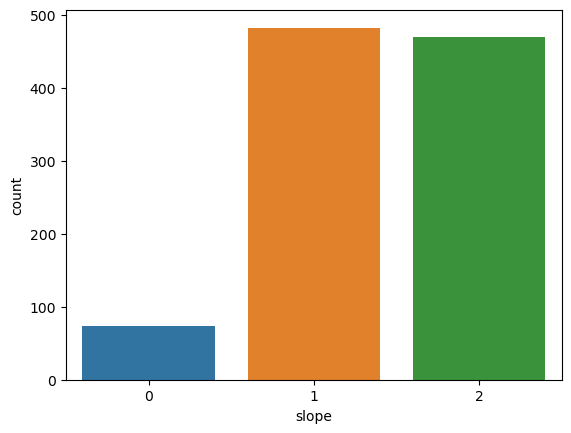

In [301]:
sns.countplot(x = "slope", data = data);

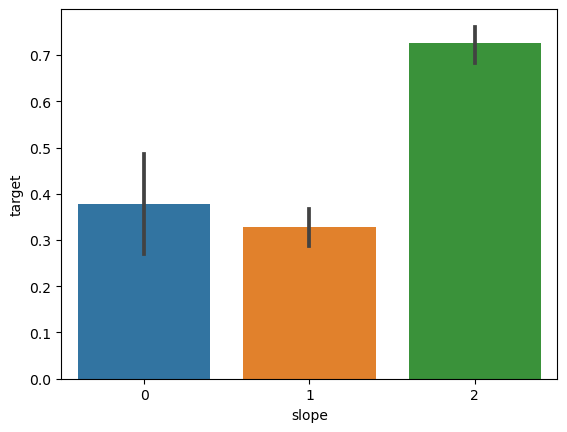

In [302]:
sns.barplot(x = "slope", y = "target", data = data);

У более чем 70% пациентов с наклоном пикового сегмента 2-го типа есть заболевание, при этом доля таких пациентов в целом велика. Преобразуем данный признак в бинарный.

In [303]:
data['slope'] = data['slope'].map(lambda s: 1 if s == 2 else 0)

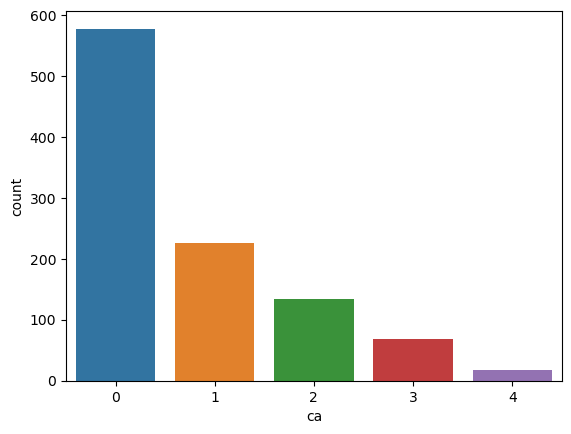

In [304]:
sns.countplot(x = "ca", data = data);

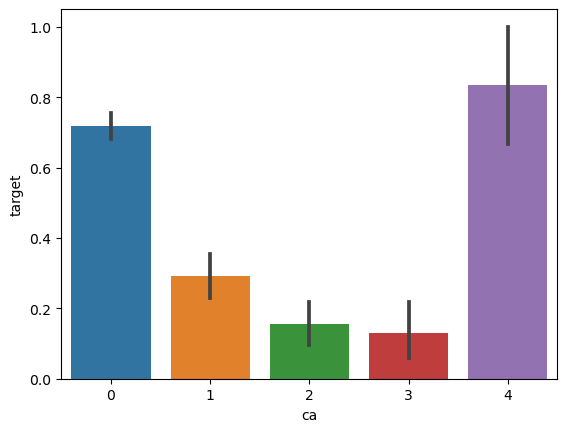

In [305]:
sns.barplot(x = "ca", y = "target", data = data);

По результатам рентгеноскопии также можно судить о наличии заболевания: пациентов, у которых на рентгеноскопии не видны (coloured) сердечные сосуды (vessels), много, и более чем у 70% из них заболевание есть. Также есть еще один крайний случай, когда видно 4 сосуда, и риск заболевания при этом тоже высок. Однако таких пациентов слишком мало в общей выборке. Преобразуем данный признак в бинарный.

In [306]:
data['ca'] = data['ca'].map(lambda c: 0 if c == 0 else 1)

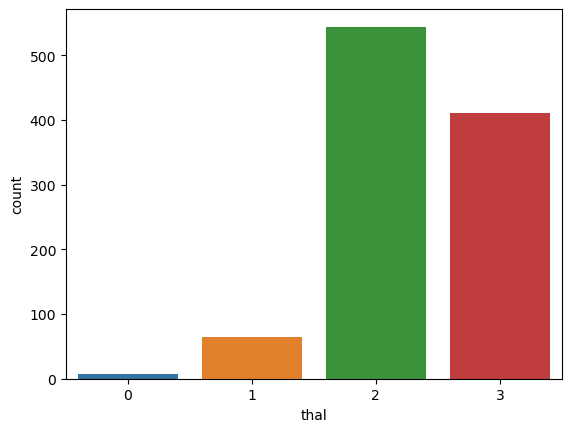

In [307]:
sns.countplot(x = "thal", data = data);

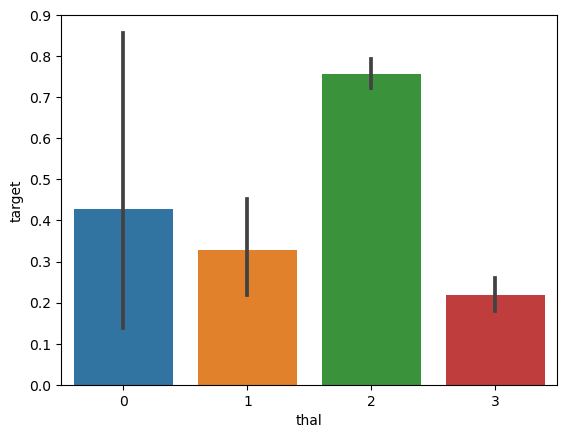

In [308]:
sns.barplot(x = "thal", y = "target", data = data);

У пациентов с диагностированной талассемией (fixed disease) вероятность порока сердца более 70%, при этом таких пациентов много. Преобразуем данный признак в бинарный.

In [309]:
data['thal'] = data['thal'].map(lambda t: 1 if t == 2 else 0)

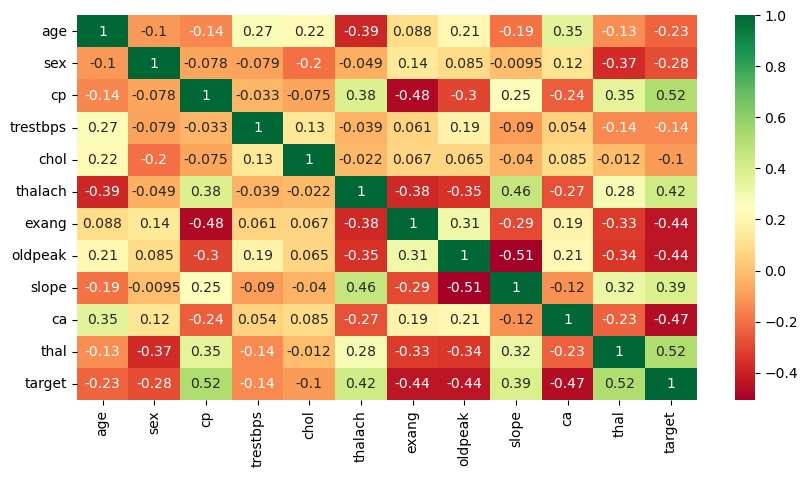

In [310]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Удалим признаки chol и trestbps -- они плохо коррелируют как с целевым признаком, так и с другими в целом.

In [311]:
data.drop(['chol', 'trestbps'], axis=1, inplace = True);

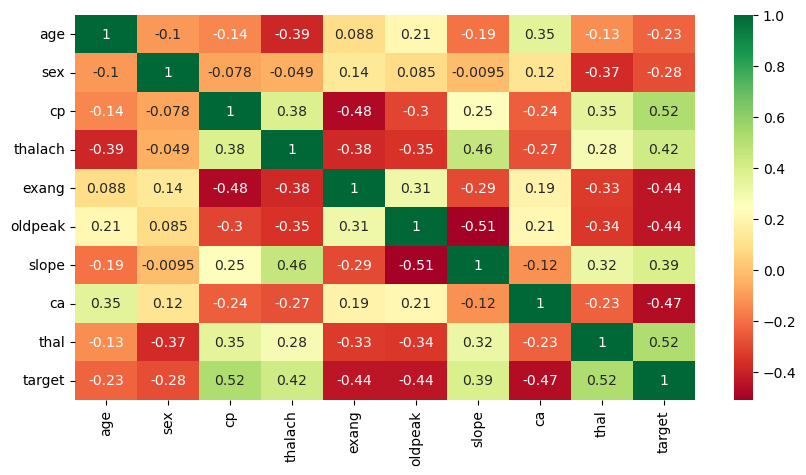

In [312]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

# 2. Анализ данных (nasa)

Предсказание "опасности" астероидов. Целевой признак: Hazardous 

Датасет: https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification

Берем только часть данных для того, чтобы обучение не шло слишком долго

In [313]:
nasa_data = pd.read_csv('nasa.csv').sample(1000)
nasa_data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
1520,3448993,3448993,21.300,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,336.363059,463.570440,0.741651,90.864144,1.602803,2.458070e+06,305.796204,0.776581,J2000,True
1806,2351545,2351545,19.700,0.305179,0.682402,305.179233,682.401509,0.189630,0.424025,1001.244233,...,10.905572,482.775869,0.790572,241.167717,1.618195,2.457900e+06,75.272459,0.745688,J2000,False
508,3752445,3752445,24.183,0.038722,0.086584,38.721750,86.584465,0.024061,0.053801,127.039866,...,66.513258,365.930969,0.896959,307.227652,1.105501,2.457664e+06,297.532106,0.983792,J2000,False
729,3015694,3015694,22.200,0.096506,0.215794,96.506147,215.794305,0.059966,0.134088,316.621227,...,1.567945,421.615057,0.755922,151.561586,1.444850,2.451209e+06,298.096088,0.853859,J2000,False
1797,3647016,3647016,24.800,0.029144,0.065169,29.144390,65.168838,0.018109,0.040494,95.618082,...,339.630066,240.831300,0.484275,175.957539,1.030819,2.458099e+06,213.204730,1.494822,J2000,False


Удалим дублирующиеся столбцы (диаметр в различных единицах измерения)

In [314]:
nasa_data.drop(['Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Miss Dist.(miles)', 'Relative Velocity km per hr'], axis=1, inplace = True)

Удалим столбцы-идентификаторы

In [315]:
nasa_data.drop(['Neo Reference ID', 'Name', 'Orbit ID'], axis=1, inplace = True)

Удалим столбцы с одинаковыми значениями

In [316]:
nasa_data.drop(['Orbiting Body', 'Equinox'], axis=1, inplace = True)

Также удалим столбец Close Approach Date: есть соответствующий ему столбец Epoch Date Close Approach, где даты представлены вещественными числами. Также удалим столбец Orbit Determination Date: все даты в нем за 2017 год, к тому же вряд ли дата определения орбиты влияет на опасность астероида.  

In [317]:
nasa_data.drop(['Close Approach Date', 'Orbit Determination Date'], axis=1, inplace = True)

In [318]:
nasa_data['Hazardous'] = nasa_data['Hazardous'].map(lambda h: 1 if h else 0)

In [319]:
nasa_data.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Epoch Date Close Approach,Relative Velocity km per sec,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Orbit Uncertainity,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
1520,21.300,0.146068,0.326618,1077436800000,13.601557,30425.322732,0.457318,177.896530,68413736.0,7,...,26.688631,336.363059,463.570440,0.741651,90.864144,1.602803,2.458070e+06,305.796204,0.776581,1
1806,19.700,0.305179,0.682402,1126162800000,14.249326,31874.317379,0.154465,60.086864,23107628.0,0,...,13.129691,10.905572,482.775869,0.790572,241.167717,1.618195,2.457900e+06,75.272459,0.745688,0
508,24.183,0.038722,0.086584,892623600000,4.097200,9165.026592,0.153979,59.898018,23035002.0,0,...,7.771396,66.513258,365.930969,0.896959,307.227652,1.105501,2.457664e+06,297.532106,0.983792,0
729,22.200,0.096506,0.215794,935305200000,8.921293,19956.039884,0.433769,168.736069,64890892.0,8,...,1.959621,1.567945,421.615057,0.755922,151.561586,1.444850,2.451209e+06,298.096088,0.853859,0
1797,24.800,0.029144,0.065169,1124089200000,20.322073,45458.444063,0.413837,160.982559,61909124.0,7,...,10.084900,339.630066,240.831300,0.484275,175.957539,1.030819,2.458099e+06,213.204730,1.494822,0


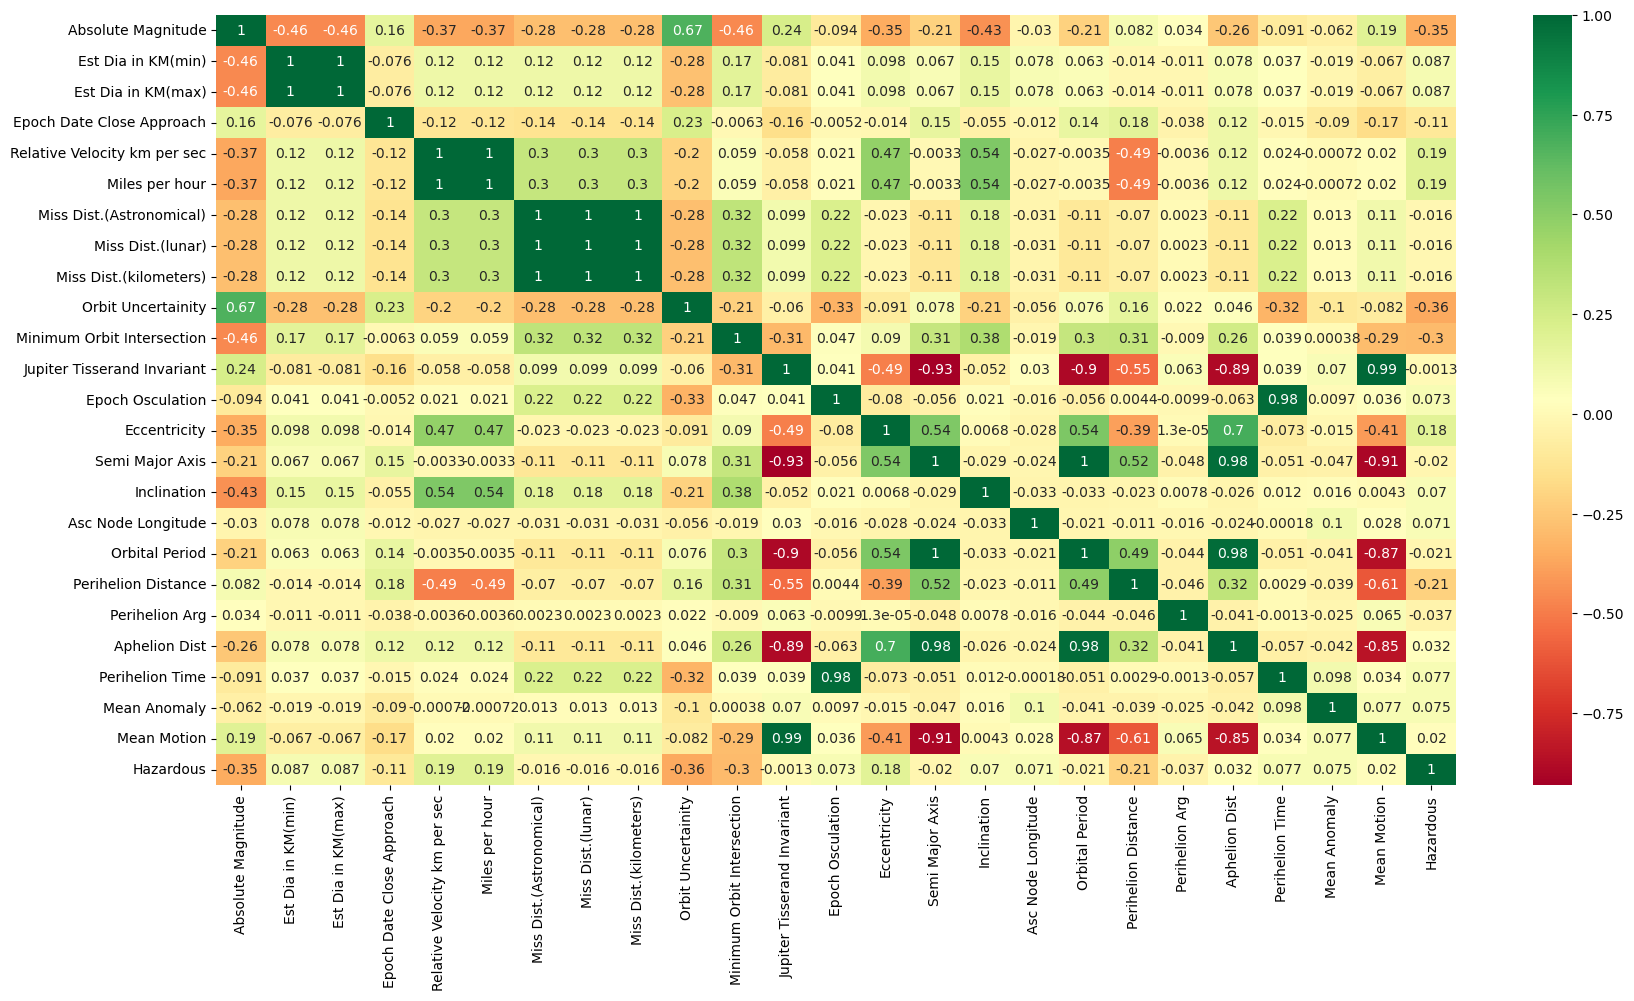

In [320]:
sns.heatmap(nasa_data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Остались избыточные признаки, удалим их

In [321]:
nasa_data.drop(['Est Dia in KM(min)', 'Miles per hour', 'Miss Dist.(kilometers)', 'Miss Dist.(lunar)', 'Semi Major Axis'], axis=1, inplace = True)

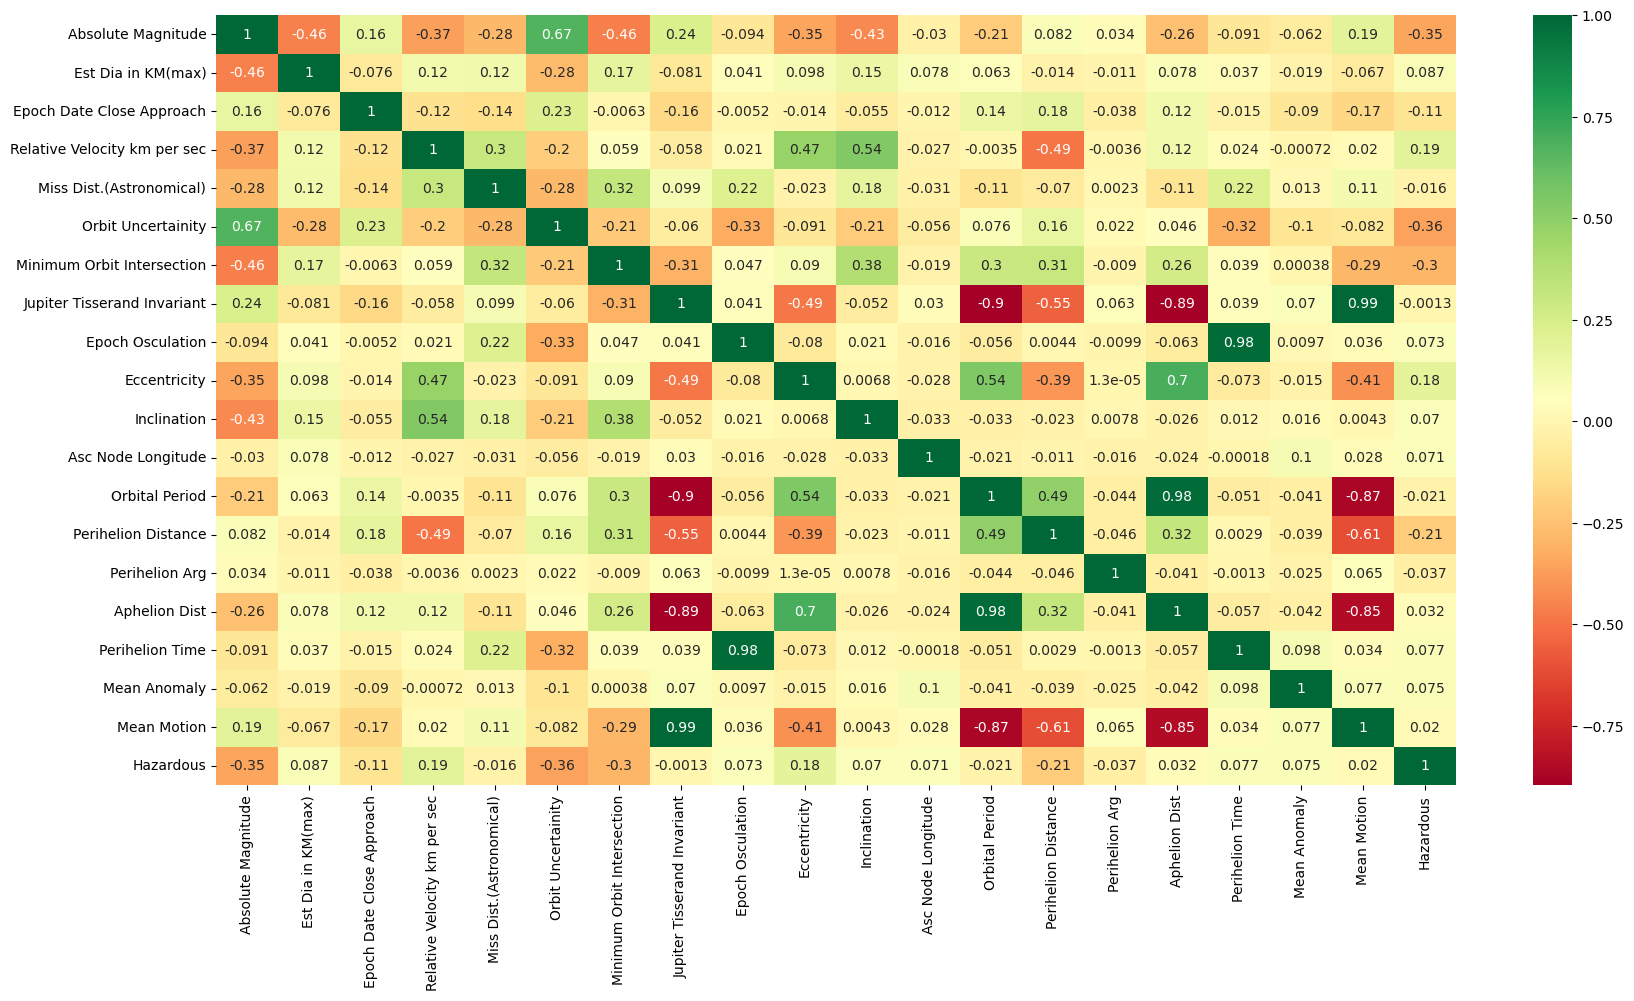

In [322]:
sns.heatmap(nasa_data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Оставим только признаки, имеющие достаточную корреляцию с целевым признаком

In [323]:
nasa_data.drop(['Epoch Date Close Approach', 'Miss Dist.(Astronomical)', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion'], axis=1, inplace = True)

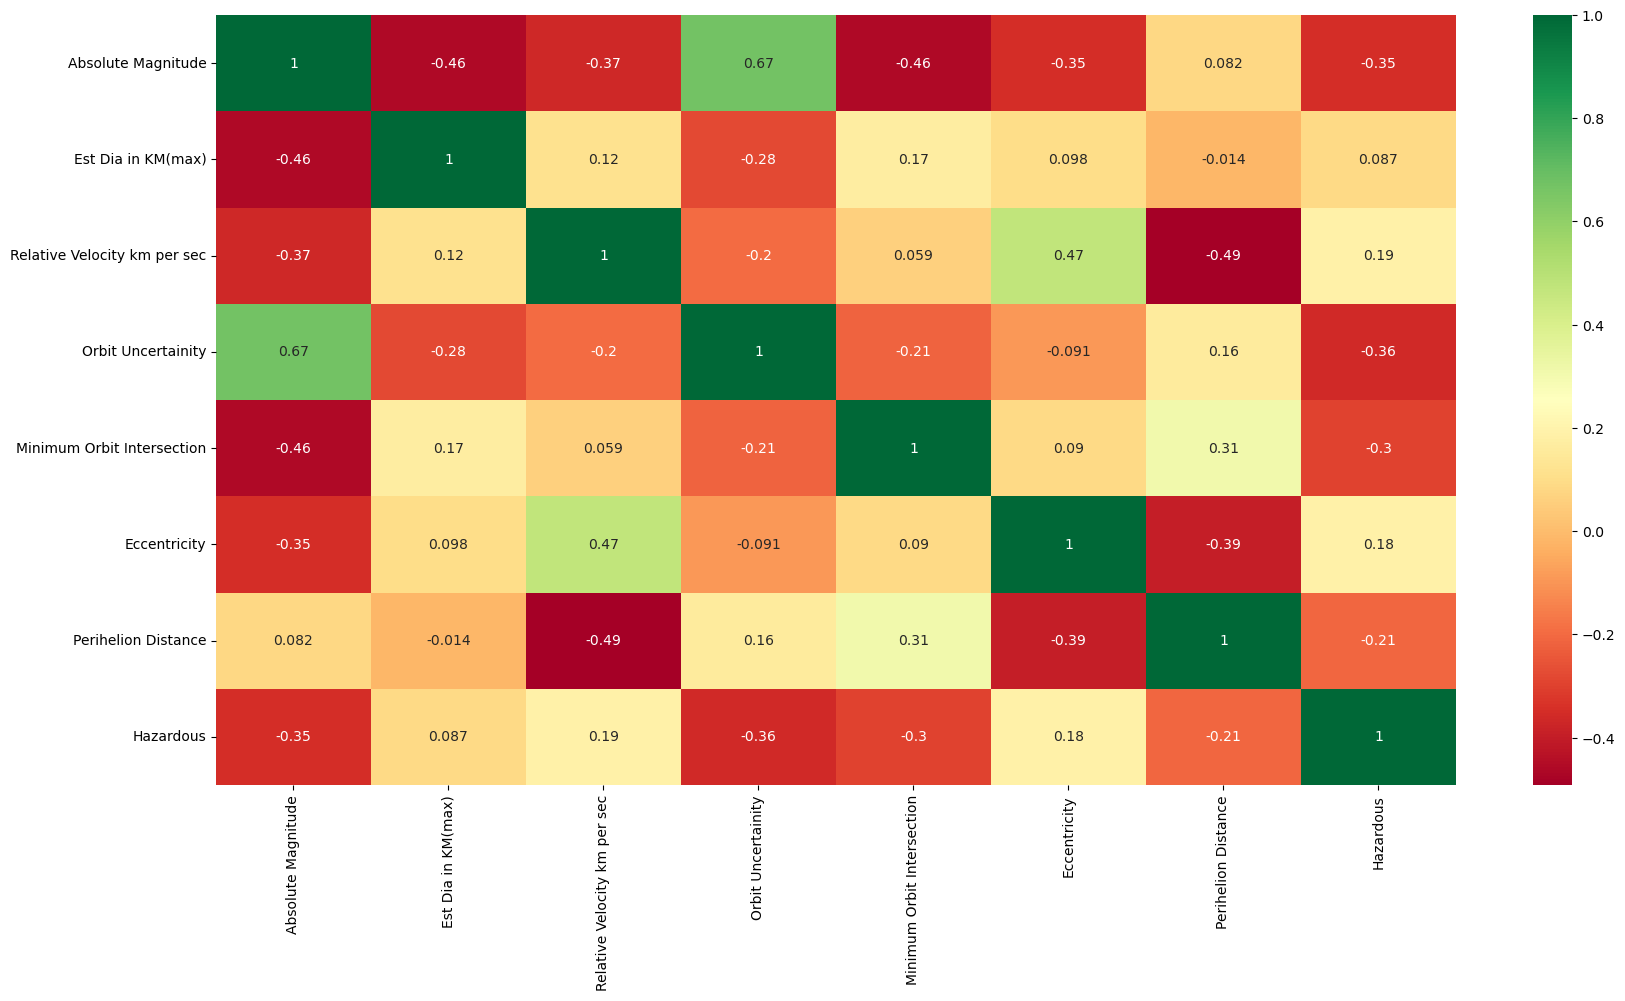

In [324]:
sns.heatmap(nasa_data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

# 3. Обучение модели

In [359]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, learning_rate=0.1, epochs_count=100):
        self.learning_rate = learning_rate  
        self.epochs_count = epochs_count

    def fit(self, X, y):
        check_X_y(X, y)
        
        ones = np.ones((X.shape[0], 1))  
        X = np.hstack((X, ones))
        self.weights = np.zeros(X.shape[1])

        for i in range(self.epochs_count):
            dot = np.matmul(self.weights, X.transpose())
            prediction = self._sigmoid(dot)
            
            # Gradient
            gradients = np.matmul(X.transpose(), prediction - y)
            gradients = np.array([np.mean(g) for g in gradients])
            
            self.weights = self.weights - self.learning_rate * gradients

    def predict(self, X):
        ones = np.ones((X.shape[0], 1))  
        X = np.hstack((X, ones))
        dot = np.matmul(X, self.weights.transpose())
        return [1 if p > 0.5 else 0 for p in self._sigmoid(dot)]

    def _sigmoid(self, x):
        def _sigmoid_inner(x):
            if x >= 0:
                z = np.exp(-x)
                return 1 / (1 + z)
            else:
                z = np.exp(x)
                return z / (1 + z)
            
        return np.array([_sigmoid_inner(v) for v in x])
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
class MyKNN(BaseEstimator):
    def __init__(self, p=2, k=5):
        self.k = k
        self.p = p

    def fit(self, X, y):
        check_X_y(X, y)
        self.X = X
        self.y = y

    def predict(self, X):
        def _predict(test_row):
            dist = [self._dist(test_row, train_row, self.p) for train_row in self.X]
            neighbours_classes = [self.y[i] for i in np.argsort(dist)[:self.k]]
            return np.argmax(np.bincount(neighbours_classes))
        return np.array([_predict(r) for r in X])

    def _dist(self, x1, x2, p):
        dist_sum = np.abs(np.sum((x1 - x2) ** p))
        return np.power(dist_sum, 1 / p)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))      

In [356]:
def fit_and_predict(X_train, y_train, X_test, y_test):    
    results = {}

    def _fit_and_predict(name, estimator, grid):
        searcher = GridSearchCV(estimator=estimator, param_grid=grid, cv=5)
        searcher.fit(X_train, y_train)
        print(searcher.best_params_)
        predictions = searcher.predict(X_test)
        matrix = confusion_matrix(y_test, predictions)
        score = accuracy_score(y_test, predictions)
        results[name] = (score, matrix)
    print('Training MyLogisticRegression...')
    _fit_and_predict(
        'MyLogisticRegression',
        MyLogisticRegression(),
        [{"learning_rate": [0.1, 0.01, 0.001], "epochs_count": [50, 100, 250]}],
    )
    print('Training MyKNN...')
    _fit_and_predict(
        'MyKNN',
        MyKNN(),
        [{"k": list(range(1, 5)), "p": [1, 2]}],
    )
    print('Training LogisticRegression...')
    _fit_and_predict(
        'LogisticRegression',
        LogisticRegression(),
        [{"max_iter": [50, 100, 250], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "penalty": ['none', 'l1', 'l2']}],
    )
    print('Training KNN...')
    _fit_and_predict(
        'KNN',
        KNeighborsClassifier(),
        [{"n_neighbors": list(range(1, 5)), "p": [1, 2]}],
    )
    print('Training SVM...')
    _fit_and_predict(
        'SVM',
        SVC(),
        [{'gamma': ['auto', 1, 0.1, 0.01], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}],
    )
    print('Training NaiveBayes...')
    _fit_and_predict(
        'NaiveBayes',
        GaussianNB(),
        [{'var_smoothing': np.logspace(0, -1, 10)}],
    )
    print('Training DecisionTree...')
    _fit_and_predict(
        'DecisionTree',
        DecisionTreeClassifier(),
        [{"max_depth": list(range(2, 30)), "min_samples_split": [5, 10, 25]}]
    )
        
    return results

In [357]:
def preprocess_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    return (X_train_scaled, X_test_scaled, y_train, y_test)

def print_results(results):
    for name, result in results.items():
        plt.title(f"{name}")
        score, matrix = result
        sns.heatmap(matrix, annot=True, fmt="d", cbar=False)
        plt.show()
        
    for name, result in results.items():
        score, matrix = result
        print(f"{name} score: {score}")

Training MyLogisticRegression...
{'epochs_count': 50, 'learning_rate': 0.001}
Training MyKNN...
{'k': 1, 'p': 2}
Training LogisticRegression...
{'max_iter': 50, 'penalty': 'none', 'solver': 'newton-cg'}
Training KNN...
{'n_neighbors': 1, 'p': 1}
Training SVM...
{'gamma': 1, 'kernel': 'poly'}
Training NaiveBayes...
{'var_smoothing': 0.1668100537200059}
Training DecisionTree...
{'max_depth': 27, 'min_samples_split': 5}


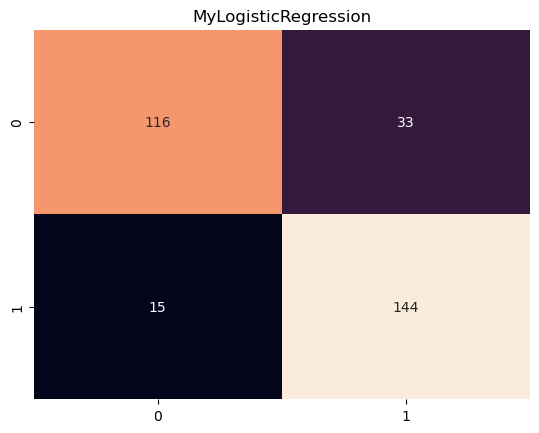

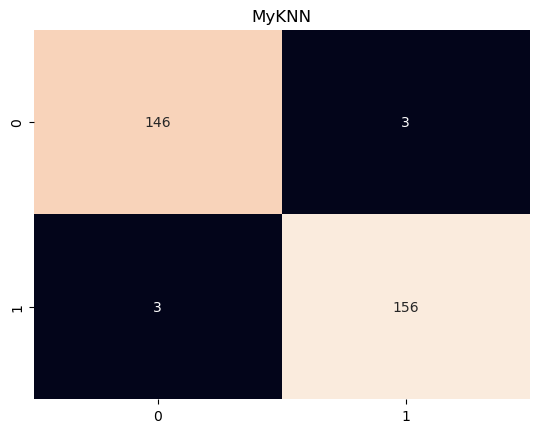

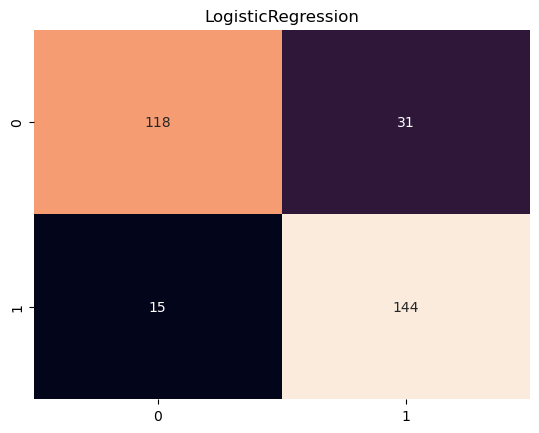

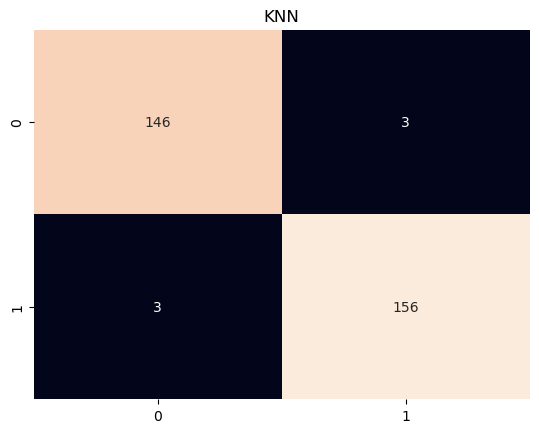

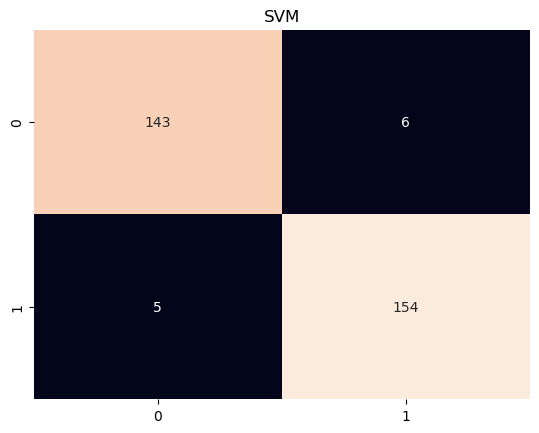

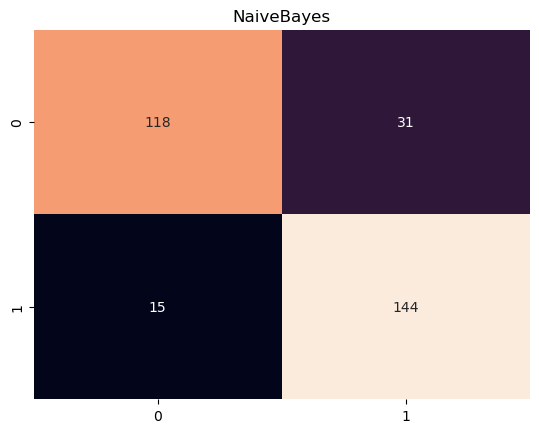

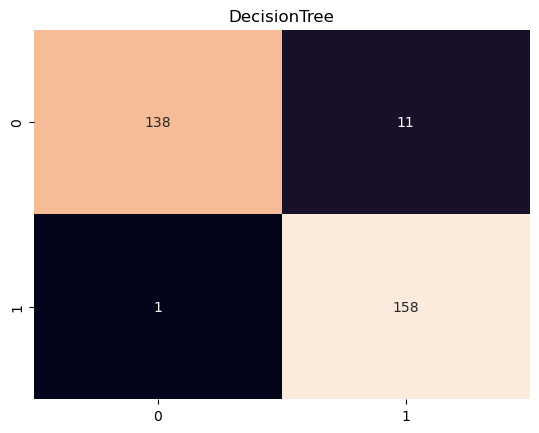

MyLogisticRegression score: 0.8441558441558441
MyKNN score: 0.9805194805194806
LogisticRegression score: 0.8506493506493507
KNN score: 0.9805194805194806
SVM score: 0.9642857142857143
NaiveBayes score: 0.8506493506493507
DecisionTree score: 0.961038961038961


In [361]:
X_heart = data.drop(columns=['target']).to_numpy()
y_heart = data['target'].to_numpy()

(X_train_heart, X_test_heart, y_train_heart, y_test_heart) = preprocess_data(X_heart, y_heart)
res = fit_and_predict(X_train_heart, y_train_heart, X_test_heart, y_test_heart)

print_results(res)

Training MyLogisticRegression...
{'epochs_count': 50, 'learning_rate': 0.01}
Training MyKNN...
{'k': 4, 'p': 2}
Training LogisticRegression...
{'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Training KNN...
{'n_neighbors': 4, 'p': 1}
Training SVM...
{'gamma': 'auto', 'kernel': 'linear'}
Training NaiveBayes...
{'var_smoothing': 0.1}
Training DecisionTree...
{'max_depth': 2, 'min_samples_split': 5}


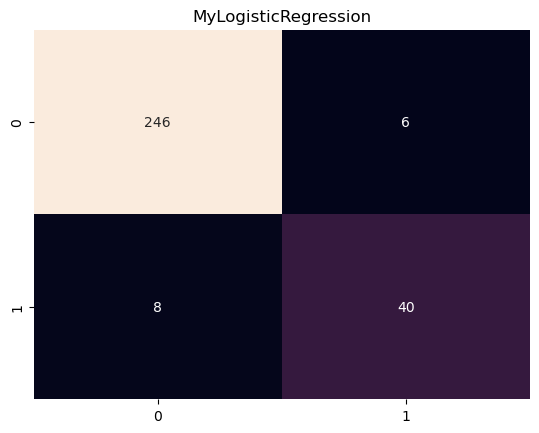

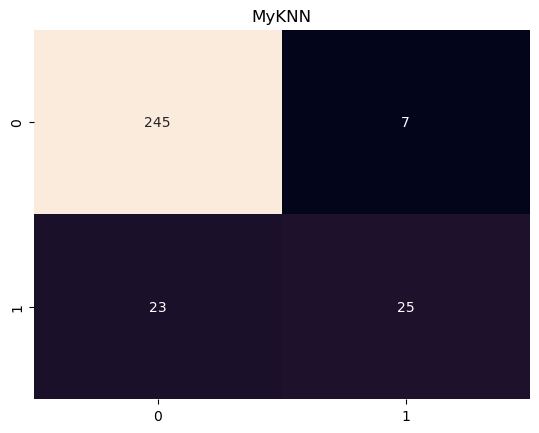

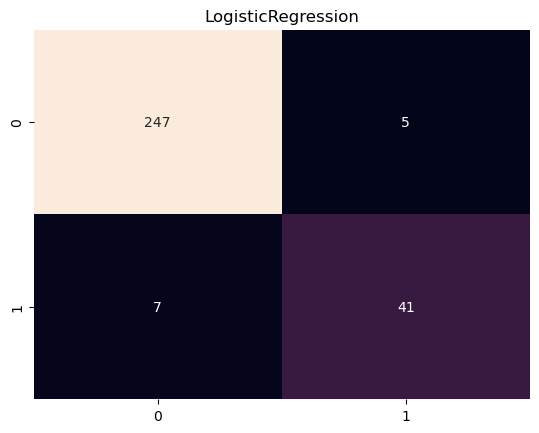

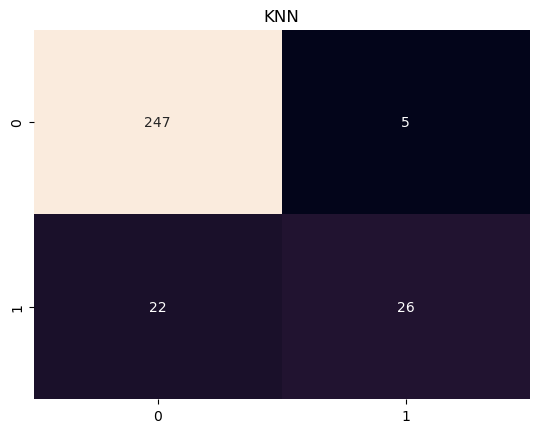

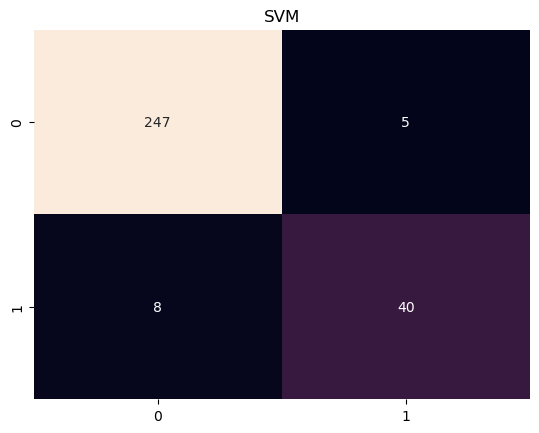

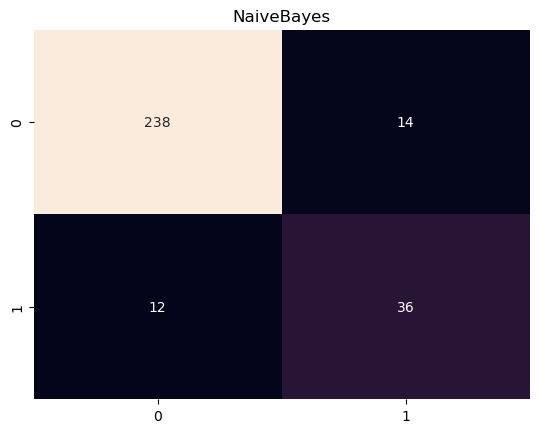

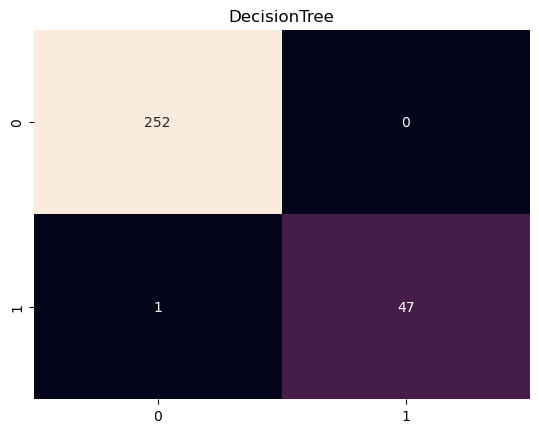

MyLogisticRegression score: 0.9533333333333334
MyKNN score: 0.9
LogisticRegression score: 0.96
KNN score: 0.91
SVM score: 0.9566666666666667
NaiveBayes score: 0.9133333333333333
DecisionTree score: 0.9966666666666667


In [360]:
X_nasa = nasa_data.drop(columns=['Hazardous']).to_numpy()
y_nasa = nasa_data['Hazardous'].to_numpy()

(X_train_nasa, X_test_nasa, y_train_nasa, y_test_nasa) = preprocess_data(X_nasa, y_nasa)

nasa_res = fit_and_predict(X_train_nasa, y_train_nasa, X_test_nasa, y_test_nasa)

print_results(nasa_res)

# Выводы:

- На данных heart лучше всего себя показывают KNN классификаторы. Вероятно, это связано с тем, что признаки хорошо коррелируют с целевым
- На данных nasa лучше всего себя показал Decision Tree классификатор. Вероятно, это связано с тем, что зависимость целевого признака от других нелинейна (например, астероид может признаваться опасным, если значения какого-либо признака лежат в определенном интервале)
- Точность реализованных классификаторов сопоставима с точностью библиотечных